# Exploração - Wikipedia

In [22]:
from repository.mongo_utils import get_pages_content_collection
from repository.wikipedia import WikipediaRepo

wikipedia_repo = WikipediaRepo(collection=get_pages_content_collection())

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns

### Obter todas as páginsa

In [24]:
pages = wikipedia_repo.find_all()

In [25]:
pages_df = pd.DataFrame(pages)
pages_df = pages_df.drop(['_id', 'ns', 'type', 'download', 'categories', 'wikitext'], axis='columns')
pages_df.head()

,pageid,title,country,text
0,22911,Geografia da Argentina,Argentina,"<div class=""mw-parser-output""><style data-mw-d..."
1,1996157,Banco Namuncurá,Argentina,"<div class=""mw-parser-output""><style data-mw-d..."
2,1393635,Campo de gelo do sul da Patagónia,Argentina,"<div class=""mw-parser-output""><style data-mw-d..."
3,3425259,Cerro de la Gloria,Argentina,"<div class=""mw-parser-output""><style data-mw-d..."
4,1753443,Chaco Austral,Argentina,"<div class=""mw-parser-output""><div style=""righ..."


### Contagem de posts

In [26]:
print(f'Foram encontradas {len(pages_df)} páginas com contéudo')

Foram encontradas 2252 páginas com contéudo


## Exploração antes da limpeza

### Tamanho médio dos documentos

In [27]:
def describe_lengths(lenghts):
    print("Measures of Central Tendency")
    print("Mean =", np.mean(lenghts))
    print("Median =", np.median(lenghts))
    print("Measures of Dispersion")
    print("Minimum =", np.amin(lenghts))
    print("Maximum =", np.amax(lenghts))
    print("Range =", np.ptp(lenghts))
    print("Varience =", np.var(lenghts))
    print("Standard Deviation =", np.std(lenghts))

In [28]:
text_lengths = pages_df['text'].apply(len)
pages_df['raw_length'] = text_lengths

Algumas considerações

- Tamanho mínimo de 799 incluindo tags html indica que pode haver documentos muito pequenos
- Desvio padrão maior que a média indica que pode haver uma variação muito grande nos tamanhos dos documentos
    * Verificar quantiles para ver a variação por quartis

In [29]:
describe_lengths(text_lengths)

Measures of Central Tendency
Mean = 34514.03285968029
Median = 30754.0
Measures of Dispersion
Minimum = 799
Maximum = 753196
Range = 752397
Varience = 1405580144.044213
Standard Deviation = 37491.067523401


In [30]:
np.quantile(text_lengths, [0, 0.25, 0.5, 0.75, 0.9, 0.95, 1])

array([   799.  ,  13731.25,  30754.  ,  41868.25,  60785.2 ,  82336.4 ,
       753196.  ])

#### Verificar distribuição de tamanhos de documentos

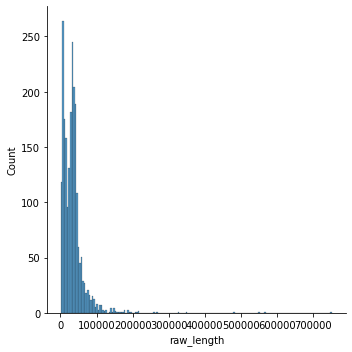

In [31]:
sns.displot(pages_df, x='raw_length')

In [32]:
# Analisar documentos acima de 100000 caracteres
pages_df_acima_100k = pages_df[pages_df['raw_length'] >= 100000]
pages_df_acima_100k.shape

(69, 5)

## Limpeza de dados

In [33]:
from limpeza.limpeza_texto import remover_html_tags

import re

In [38]:
texts = pages_df['text'].values
texto = texts[0] 


### Primeira  tentativa - removendo elementos individualmente

In [95]:
t = remover_html_tags(texto)
t = re.sub('body\.skin\-[a-z]+ ', '', t)
t = re.sub('.mw\-parser-[a-z]+ ', '', t)
t = re.sub('t[hd]\.mbox\-[a-z]+[ ,]', '', t)
t = re.sub('table\.[acfiot]mbox,', '', t)
t = re.sub('table\.[acfiot]mbox\-[a-z]+,', '', t)
t = re.sub('\.[ait]mbox[ ,]', '', t)
t = re.sub('\.mbox\-[a-z]+[ ,]', '', t)
t = re.sub('\.tmbox\.mbox\-[a-z]+[ ,]', '', t)
t = re.sub('\.mediawiki ', '', t)
t = re.sub('\.compact-ambox[ ,]', '', t)

print(f'Tamanho do texto : {len(t)}/{len(texto)}')


Tamanho do texto : 29919/140685


### Segunda tentativa

- Peguei o conteúdo html, colei em um formatador externo e decidi tomar as seguintes ações
    * Remover tag ```<scripts>``` e todo seu conteúdo interno

In [ ]:
re

In [101]:
# Pegando segundo texto, que tem tamanho 33027, mais perto da media
# [len(t) for t in texts[:20]]

texto = texts[3]

In [86]:
t = re.sub('<style .*?style>', '', texto) # Removendo tag de estilos
print(f'Tamanho do texto apos remocao de estilos: {len(t)}/{len(texto)}. Aproximadamente {(len(t)/len(texto)) * 100:.2f}% mantido')

t = re.sub('\n', '', t)
t = re.sub('<table class="box-Sem_fontes.*?/table>', '', t)
t = re.sub('<!--.*?-->', '', t) # Remover comentarios
print(f'Tamanho do texto apos remocao conteudo: {len(t)}/{len(texto)}. Aproximadamente {(len(t)/len(texto)) * 100:.2f}% mantido')


Tamanho do texto apos remocao de estilos: 7185/33027. Aproximadamente 21.75% mantido
Tamanho do texto apos remocao conteudo: 3799/33027. Aproximadamente 11.50% mantido


## Extração de parágrafos

Após conseguir remover um pouco de texto na tentativa 2 anterior vamos extrair apenas textos de parágrafos e ver como fica o resultado. Um risco nesta abordagem é tirar conteúdos interessantes de tabelas ou listas mas deixar este problema de lado por enquanto.

- **Vou ignorar inclusive a limpeza de texto feito previamente e ir direto aos parágrafos.**
- **Avaliar possibilidade de pegar conteúdo <pre></pre>.**

- Uma análise posterior de tamanho dos documentos deve ser feita
- Deve-se remover tags html de dentro dos parágrafos pois estes podem conter elementos como links ou spans
    * **Isto é bem resolvido pelo método getText() do BeautifulSoup quando aplicado ao elemento p**

In [88]:
from bs4 import BeautifulSoup

In [102]:
soup = BeautifulSoup(texto, 'html.parser')

In [103]:
ps = soup.find_all('p')

In [104]:
[p.getText() for p in ps]

['\nPico  da Glória é um morro (cerro) próximo a cidade argentina de Mendoza, quase na divisa com o Chile. Seu nome original, “Monte Pilar” (Cerro del Pilar) foi transformado no atual  por decreto do poder Executivo no dia 30 de janeiro de 1913.  Sobre o monte há um monumento com o mesmo nome -  Morro da Glória -  em homenagem à vitória do exército do general José de San Martin, que atravessou a cordilheira dos Andes entre os dias 12 de janeiro e 8 de fevereiro de 1817, para vencer  tropas espanholas que resistiam à independência Argentina. Vencendo os espanhóis, San Martin acabou promovendo a independência do Peru e do Chile, mas, os revolucionários,  cuja liderança era disputada entre Montevidéu e Buenos Aires, acabou perdendo  o Alto Peru, atual Bolívia e a Banda Oriental, atual Uruguai, este último\n']

In [100]:
pages_df.iloc[:5]

,pageid,title,country,text,raw_length
0,22911,Geografia da Argentina,Argentina,"<div class=""mw-parser-output""><style data-mw-d...",140685
1,1996157,Banco Namuncurá,Argentina,"<div class=""mw-parser-output""><style data-mw-d...",33027
2,1393635,Campo de gelo do sul da Patagónia,Argentina,"<div class=""mw-parser-output""><style data-mw-d...",46988
3,3425259,Cerro de la Gloria,Argentina,"<div class=""mw-parser-output""><style data-mw-d...",34210
4,1753443,Chaco Austral,Argentina,"<div class=""mw-parser-output""><div style=""righ...",35169
